#UV treated Silk pattern decomposition
#Instead of using full 9 peaks, this script will instead use "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system
Author links open overlay panelMehtapFevziogluabOguz KaanOzturkbcBruce R.HamakerbcOsvaldo H.Campanellabd" and only analyze 4 "peaks"
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)

This notebook is bsed on a previously developed tool demonstrating how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff
6.2.22: Apply FSD to spectra as I don't think this is being applied here before the least-squares fitting method




Setup, Import Code

In [13]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import sys
sys.path.append("../")
import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file


In [14]:
# import data file in csv format

rawData_df = pd.read_csv(r"C:\Users\jrosh\ftir_data_analytics\data\WaDriedMeOH9x2.csv", header=None) 

In [15]:
#dim1 = np.array([1:1:25])
dims = []
for i in range(1,rawData_df.shape[1]):
    dims.append(f"cols{i}")
    # for j in range(1,26):
    #     dims.append(str([i,j]))

In [16]:
column_names = list(['wavenumber'])+ dims
type(column_names[3])

str

In [17]:
beta_sheet_df = pd.DataFrame(rawData_df.values, columns = column_names)

In [18]:
# beta_sheet_df.head()

## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.

In [19]:
# imports
%matplotlib inline

from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990
from ftir.io.utils import create_df_from_single_file

In [20]:
#only show between 1715 and 1600, previously had (1725, 1595)
corrected_beta_sheet = []
for cols_ in beta_sheet_df.columns[1:]:
    #print(str(cols_))
    corrected_beta_sheet.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

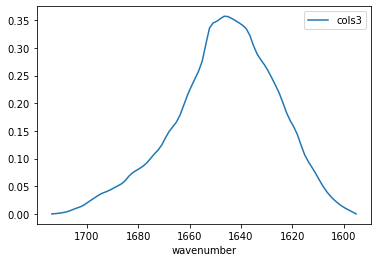

In [21]:
#corrected_df = sd_baseline_correction(beta_sheet_df, cols=['cols1'], flip=False, method='rubberband', bounds=(1725, 1595))
corrected_beta_sheet[2].plot.line(x='wavenumber', y=corrected_beta_sheet[2].columns[1]).invert_xaxis()

In [47]:
#this is in peak_fitting but I'm putting it here too because Ritwika did
import math
import matplotlib.pyplot as plt
#this below doesn't work!!!
reluncert = 5
gainnum = 0.90
#from ftir.modeling.peak_definitions import hu_Kaplan_Cebe_2006_actual
hu_Kaplan_Cebe_2006_rounded = {
    'means': [1610, 1619, 1625, 1633,  1642, 1650, 1659, 1667, 1679, 1692, 1700],
    'uncertainties': [(1605, 1615), (1616, 1621), (1622, 1627), (1628, 1637),
                      (1638, 1646), (1647, 1655), (1656, 1662), (1663, 1670),
                      (1671, 1685), (1686, 1696), (1697, 1703)],
    'relative_uncertainties': [5, 2.5, 2.5, 4.5, 4, 4, 3, 3.5, 7, 5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate \u03B2-strand/\u03B2-sheet(weak)', 
                    'intermolecular \u03B2-sheet (strong)', 'intramolecular \u03B2-sheet (strong)^b',
                    'random coils/extended', 'random coils', '\u03B1-helices', 'turns',
                    'turns', 'turns', 'intermolecular \u03B2_sheets (weak)']
}

six_peak = {
    'means': [1610, 1625,  1646, 1659, 1679, 1700],
    'uncertainties': [(1605, 1615), (1616, 1637),
                      (1638, 1646), (1647, 1662), (1663, 1696), (1697, 1703)],
    'relative_uncertainties': [5, 10.5, 4, 7.5, 16.5, 3],
    'assignments': ['(Tyr) side chains/aggregate strands', 'aggregate beta-strand/beta_sheet',
                    'random coils', '\u03B1-helices', 'turns', 'intermolecular beta_sheets (weak)']
}

four_peak = {
    'means': [1627,  1650, 1679,1700],
    'uncertainties': [(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
    #'relative_uncertainties': [10, 12, 16,3],
    'relative_uncertainties': [2, 2, 1,2],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}

five_peak = {
    'means': [1610, 1627, 1650, 1679,1700],
    'uncertainties': [(1605,1615),(1620, 1633), (1640, 1660), (1663, 1696), (1697, 1703)],
    'relative_uncertainties': [5,5, 5, 5,5],
    # 'uncertainties': [(1605,1615),(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
    # 'relative_uncertainties': [5,5, 5, 5,5],
    'assignments': ['side-chains', 'aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}


six_peak2 = {
    'means': [1610, 1627, 1646, 1659, 1679,1700],
    'uncertainties': [(1605,1615),(1620, 1637), (1638,1655), (1656,1662), (1663, 1696), (1697, 1703)],
    'relative_uncertainties': [reluncert,reluncert,reluncert,reluncert,reluncert,reluncert],
    # 'uncertainties': [(1605,1615),(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
    # 'relative_uncertainties': [5,5, 5, 5,5],
    'assignments': ['side-chains', 'aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils', '\u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}

from scipy import optimize
from scipy.spatial import ConvexHull

def gaussian_least_squares_(df, col, peaks,
                           peak_width, params=dict()): # peak width taken from: 
                           # "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"

    def fun(p, x, y):
        """ Minimizing across parameter space p, for a given range, x"""
        return gaussian_sum(x, *p) - y

    data = np.array(pd.concat([df.iloc[:,0], df[col]], axis=1))
    heights = guess_heights_(df, col, peaks['means'], gain=gainnum)
    width = peak_width
    lb = list()
    ub = list()
    guess = list()

    # Make 1-D array for optimization func definition above
    for mean, bound, height in zip(peaks['means'], peaks['uncertainties'],
                                   heights):
        lb.extend([0, bound[0], 0])
        ubh = np.inf if height <= 0 else height
        ub.extend([ubh, bound[1], peak_width*1])
        guess.extend([height*0.95, mean, peak_width])

    args = [fun, np.array(guess)]
    params['args'] = (data[:, 0], data[:, 1])
    params['bounds'] = (np.array(lb), np.array(ub))
    res = optimize.least_squares(*args, **params)

    areas = list()
    for i in range(0, len(res.x), 3):
        height = res.x[i]
        width = res.x[i+2]
        area = gaussian_integral(height, width)
        areas.append(area)
    return areas, res

def guess_heights_(df, col, center_list, gain=0.90):
    """ Determines guesses for the heights based on measured data.

    Function creates an integer mapping to the measured frequencies, and then
    creates an initial peak height guess of gain*actual height at x=freq*. A
    Default of 0.95 seems to work best for most spectra, but can be change to
    improve convergence.

    Parameters
    ----------
    df : Dataframe
        Dataframe containing the measured absorbance data

    col : string or integer
        Column index for the absorbance data being fit. Accepts either index
        or string convention.

    center_list : iterable of integers
        An iterable of integer peak positions used to find the experiment
        absorbance at a given wavenumber. I.e, the heights are returned at the
        center values in this iterable

    gain : number (optional)
        Fraction of the measured absorbance value to use determine the initial
        guess for the peak height. The value Default value is 0.95, and thus
        by default, all initial peak guesses are 95% of the peak max.

    """
    heights = []
    freq_map = {}
    for i in df.iloc[:,0]:
        j = math.floor(i)
        freq_map[j] = float(df[col].get(df.iloc[:,0] == i))
    print(freq_map)
    # pdb.set_trace()
    for i in center_list:
        height = freq_map[i]
        heights.append(gain*height)
    return heights

Plotting spectra and their invidual fits

In [42]:
str(four_peak['relative_uncertainties'])

'[2, 2, 2, 2]'

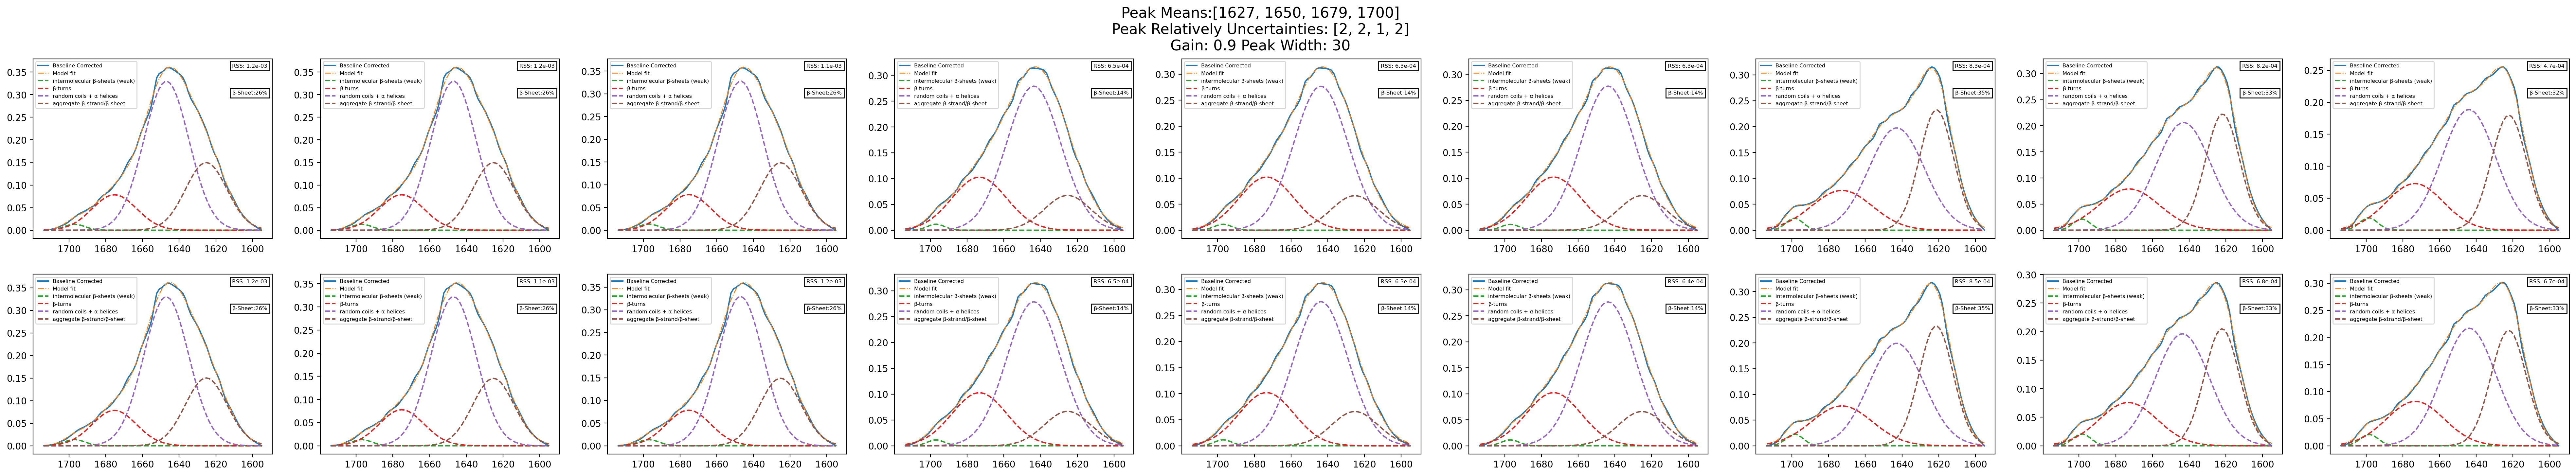

In [98]:
#Commented on 5/24/2022 as something with subplots isn't working well; instead using individual plots for now from intensity ratiomarch21half methanol
pw = 30
peakfitlibname = 'four_peak'
peaksfittinglib = four_peak 


from matplotlib.offsetbox import AnchoredText

#fig, axs = plt.subplots(8,8, figsize=(20,15),dpi=200)
#fig.set_size_inches(30,20)
fig, axs = plt.subplots(2,9, figsize=(50,8),dpi=200)
titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
    "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
fig.suptitle(titletext, fontsize=16)
fig.subplots_adjust(hspace=.2, wspace=.2)
#plt.tight_layout()
axs = axs.flatten()



structs =[]
gaussian_data = []
for i in range(0,len(corrected_beta_sheet)):
#for i in range(0,4):    
    sample = corrected_beta_sheet[i].columns[1]
    area, res = gaussian_least_squares(corrected_beta_sheet[i], corrected_beta_sheet[i].columns[1], peak_width=pw, 
                                    peaks=peaksfittinglib, params={'loss':'linear'}) 
    #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
    structs.append(secondary_structure(area, peaksfittinglib))
    gaussian_list_data = gaussian_list(corrected_beta_sheet[i]['wavenumber'], *res.x)
    gaussian_data.append(gaussian_list_data)
    
    xdata = corrected_beta_sheet[i].iloc[:,0]
    y_fit = sum(gaussian_list_data)

    axs[i].plot(xdata, corrected_beta_sheet[i][sample],label='Baseline Corrected') #Jeff changed this to Original from '$2^{nd}$ derivative' on 3.23.2022
    axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) #Jeff changed this to Original from '$2^{nd}$ derivative' on 3.23.2022
    
    # calculate RSS for each spectrum
    resid = corrected_beta_sheet[i][sample] - y_fit
    # sum of square residuals - want to minimize this, might need to run some algorithm to do this
    rss = sum(resid*resid)

    # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
    for j in range(len(gaussian_list_data)):
        axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-j], ls='--', 
        label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-j])) #label=str(structs[j][1])) #label='')
    axs[i].invert_xaxis()
    
    legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
    #axs[i].add_artist(legend1)
    rssTitle = "RSS: "+ str("{:.1e}".format(rss))
    rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)
                      
    ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] +
     structs[i]['intermolecular \u03B2-sheets (weak)']))
    
    axs[i].add_artist(rssText)
    aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
                       bbox_transform=axs[i].transAxes)
    axs[i].add_artist(aRatioText)
plt.show()


In [19]:
len(structs)
corrected_beta_sheet[5].columns[0]

'wavenumber'

In [32]:
type(structs)

five_peak['assignments'][1]

#structs[1]

'random coils + alpha helices'

In [50]:
structs[1]["random coils + \u03B1 helices"]
#type(corrected_beta_sheet)

0.46972142330148475

In [55]:
# corrected_beta_sheet

In [ ]:
index = 1
sample = corrected_beta_sheet.columns[index]
print("Analyzing {}".format(corrected_beta_sheet.columns[index]))
area, res = gaussian_least_squares(corrected_beta_sheet, corrected_beta_sheet.columns[index], peak_width=15, 
                                   peaks=six_peak, params={'loss':'linear'})
structs = secondary_structure(area, six_peak)
gaussian_list_data = gaussian_list(corrected_beta_sheet['wavenumber'], *res.x)
plt = create_fit_plots(corrected_beta_sheet, sample, gaussian_list_data)
plt.show()
print(structs)

Attempt to compare area of beta sheet vs random coils out 

In [59]:
ratio_1 = []
ratio_2 = []
for i in range(0,len(structs)):
    ratio_1.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
    #ratio_2.append(structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])/(structs[i]['\u03B1-helices']+structs[i]['random coils']+structs[i]['turns']+structs[i]['(Tyr) side chains/aggregate strands']+structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])

#commented 6/9/22 in case what I had before worked -Jeff
# ratio_1 = []
# ratio_2 = []
# for i in range(0,len(structs)):
#     ratio_1.append(structs[i]['aggregate beta-strand/beta_sheet'] + structs[i]['intermolecular beta_sheets (weak)'])
#     #ratio_2.append(structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])/(structs[i]['\u03B1-helices']+structs[i]['random coils']+structs[i]['turns']+structs[i]['(Tyr) side chains/aggregate strands']+structs[i]['aggregate beta-strand/beta_sheet']+structs[i]['intermolecular beta_sheets (weak)'])


In [60]:
len(ratio_1)

18

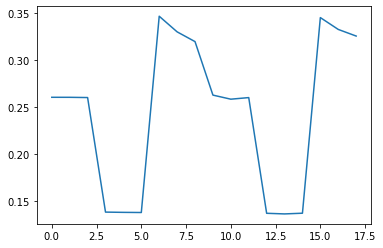

In [61]:
plt.plot(ratio_1)

In [ ]:
# (structs['aggregate beta-strand/beta_sheet']+structs['intermolecular beta_sheets (weak)']) # ANSWER FOR ONE COLUMN NEEDED FOR ALL

In [43]:
import seaborn as sns

In [ ]:
# commented on 6/9/22 as I think I've done this above? -Jeff

# index = 1
# sample = corrected_df.columns[index]
# print("Analyzing {}".format(corrected_df.columns[index]))
# area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=15, 
#                                    peaks=six_peak, params={'loss':'linear'})
# structs = secondary_structure(area, six_peak)
# gaussian_list_data = gaussian_list(corrected_df['wavenumber'], *res.x)
# plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
# plt.show()
# print(structs)

# #Plot each 6 peak deconvolution result 


# # sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
# #            col_wrap=2, ci=None, palette="muted", height=4,
# #            scatter_kws={"s": 50, "alpha": 1})

In [76]:
# set the x dimension of the plot of raw data (data collected in a grid, so there should be an x and y for converting csv into image)
num_in_y = 2
num_in_x = 9
break_ratio_1 = np.array_split(np.array(ratio_1),num_of_rows)

In [72]:
break_ratio_1[0:2]

[array([0.26069979, 0.26067404]), array([0.26041921, 0.13849007])]

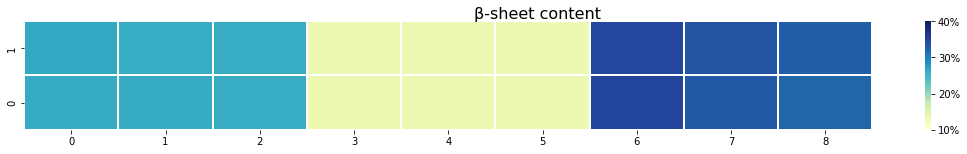

In [124]:


#f,ax_example = plt.subplots()

plt.figure(figsize = (19,2))

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_ratio_1[0:(num_in_x-1)], cmap="YlGnBu",vmin=.1, vmax=0.4, linewidths=.05)
#ax_example.set_title(hmtitletext, fontsize=16)
plt.suptitle(hmtitletext , fontsize=16)

#ax_example.figsize=(25,4)
# titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
    # "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
#ax_example.title("\u03B2-sheet", fontsize=16)
fig.subplots_adjust(hspace=.2, wspace=.2)
ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([.1,0.2,0.3,.4])
cbar.set_ticklabels(['10%', '20%', '30%','40%'])

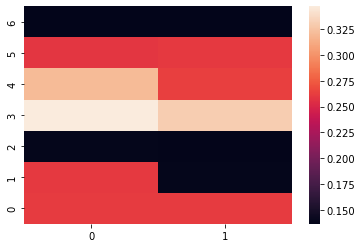

In [67]:
# ax = sns.heatmap(break_ratio_1[0:7])
# ax.invert_yaxis()

In [ ]:
len(break_ratio_1)

In [ ]:

#ratio_subsection = [ratio_1[0:7], ratio_1[8:15],ratio_1[16:23],ratio_1[24:31],ratio_1[32:39],ratio_1[40:47],ratio_1[48:55],ratio_1[56:63]]
# commented below on 6/9/22 as 
#ratio_subsection = [ratio_1[56:63],ratio_1[48:55],ratio_1[40:47],ratio_1[32:39],ratio_1[24:31],ratio_1[16:23],ratio_1[8:15],ratio_1[0:7]]

ratio_subsection = [ratio_1[56:63],ratio_1[48:55],ratio_1[40:47],ratio_1[32:39],ratio_1[24:31],ratio_1[16:23],ratio_1[8:15],ratio_1[0:7]]


In [ ]:
sns.heatmap(ratio_subsection)

In [ ]:
pd.DataFrame(ratio_1[1:21]).corr()

## Peak fitting results


In [ ]:
from copy import deepcopy
new_peaks = deepcopy(yang_h20_2015)
new_peaks['means'].append(1610)
new_peaks['assignments'].append('side-chain')
new_peaks['uncertainties'].append((1606, 1616))
new_peaks['relative_uncertainties'].append(4)

In [ ]:
index = 1
sample = corrected_df.columns[index]
print("Analyzing {}".format(corrected_df.columns[index]))
area, res = gaussian_least_squares(corrected_df, corrected_df.columns[index], peak_width=1.5, peaks=new_peaks)
structs = secondary_structure(area, new_peaks)
gaussian_list_data = gaussian_list(corrected_df['freq'], *res.x)
plt = create_fit_plots(corrected_df, sample, gaussian_list_data)
plt.show()
print(structs)

In [ ]:
###SKIPPING bc derivative not needed


#2nd derivative data from original spectra
#need to figure out how the indexing works as taking differences means we lose one value in the x-dimension (wavenumber) here
corrected_df['wavenumber']
corrected_df_1stDerivative = np.diff(corrected_df['1,1'])/np.diff(corrected_df['wavenumber'])
corrected_df_2ndDerivative = np.diff(corrected_df_1stDerivative)/np.diff(corrected_df['wavenumber'][0:90])

#corrected_df_2ndDerivative = np.diff(corrected_df, 2)
#print(corrected_df_2ndDerivative)
# #print(corrected_df_1stDerivative)
# print(corrected_df_1stDerivative)
# print(corrected_df_2ndDerivative)
# type(corrected_df_1stDerivative)
#corrected_df['wavenumber']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211)
ax.plot(corrected_df['wavenumber'][1:91], corrected_df_1stDerivative, label='$1^{st}$ derivative')
ax.plot(corrected_df['wavenumber'][1:90], corrected_df_2ndDerivative, label='$2^{nd}$ derivative')
ax.legend(loc=1)
# # corrected_df_2ndDerivative = corrected_df.derivative(n=2)
# from scipy.interpolate import UnivariateSpline

# y_spl = UnivariateSpline(x,y,s=0,k=4)
# #plt.plot(x_range,y_spl_2d(x_range))